# ViT Embedding + QoS Feature Exploration

This notebook explores relationships between ViT image embeddings and 
our binary QoS / anomaly labels for the AlertCalifornia camera dataset.

Goals:

- Check basic data health (shape, missing values, label balance).
- Look at how embeddings separate by label in a low-dimensional view (PCA).
- Compute simple per-camera summary statistics that might be useful
  as future "camera health" features.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

sns.set(style="whitegrid", context="notebook")

# ==== PATH & COLUMN CONFIG (EDIT IF NEEDED) ==========================
# Try to match real file + column names in the repo.
EMBEDDING_CSV_PATH = "camera_data/coronado_hills_binary_11-15-2025.csv"

# Name of the label column (0/1 or "good"/"bad")
LABEL_COL = "label"          # <-- change if your column is called something else
CAMERA_COL = "camera_id"     # <-- change if your file uses a different name
TIME_COL = "timestamp"       # <-- optional, only if available

EMBED_PREFIX = "embed_"      # assume embedding columns look like embed_0, embed_1, ...
# ====================================================================

In [2]:
if not os.path.exists(EMBEDDING_CSV_PATH):
    raise FileNotFoundError(
        f"Could not find {EMBEDDING_CSV_PATH}. "
        "Update EMBEDDING_CSV_PATH at the top of this notebook to the correct file."
    )

df = pd.read_csv(EMBEDDING_CSV_PATH)

print("Shape:", df.shape)
print("Columns:", list(df.columns)[:20], " ...")

df.head()

Shape: (7492, 9)
Columns: ['annotation_id', 'annotator', 'choice', 'created_at', 'id', 'image', 'lead_time', 'ptz', 'updated_at']  ...


,annotation_id,annotator,choice,created_at,id,image,lead_time,ptz,updated_at
0,31490,9,NaN,2025-10-15T16:26:55.240265Z,1036838,https://tools.alertcalifornia.org/fireframes5/...,30.403,"{""pan"":174.07000732421875,""tilt"":-0.1700000017...",2025-10-15T16:26:55.240273Z
1,31491,9,Abnormal,2025-10-15T16:27:02.561202Z,1036839,https://tools.alertcalifornia.org/fireframes5/...,6.945,"{""pan"":174.07000732421875,""tilt"":-0.1700000017...",2025-10-15T16:27:02.561209Z
2,31492,9,Abnormal,2025-10-15T16:27:09.104112Z,1036840,https://tools.alertcalifornia.org/fireframes5/...,6.047,"{""pan"":174.07000732421875,""tilt"":-0.1700000017...",2025-10-15T16:27:09.104125Z
3,31493,9,Abnormal,2025-10-15T16:27:11.885629Z,1036841,https://tools.alertcalifornia.org/fireframes5/...,2.271,"{""pan"":174.07000732421875,""tilt"":-0.1700000017...",2025-10-15T16:27:11.885644Z
4,31494,9,Abnormal,2025-10-15T16:27:14.704204Z,1036842,https://tools.alertcalifornia.org/fireframes5/...,2.290,"{""pan"":174.07000732421875,""tilt"":-0.1700000017...",2025-10-15T16:27:14.704218Z


Label value counts:


choice
NaN         3895
Abnormal    3597
Name: count, dtype: int64

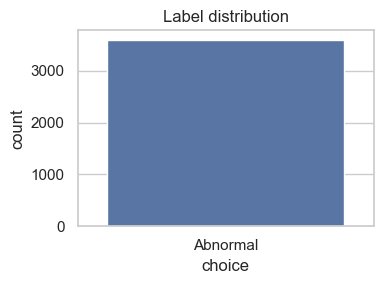

Label value counts:


choice
NaN         3895
Abnormal    3597
Name: count, dtype: int64

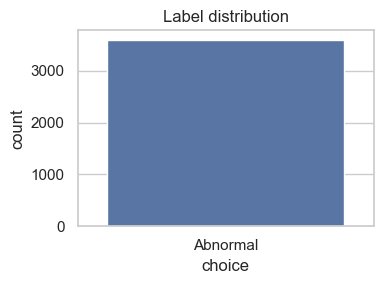

In [5]:
# Label distribution
LABEL_COL = "choice"
if LABEL_COL in df.columns:
    print("Label value counts:")
    display(df[LABEL_COL].value_counts(dropna=False))

    plt.figure(figsize=(4,3))
    sns.countplot(x=LABEL_COL, data=df)
    plt.title("Label distribution")
    plt.tight_layout()
    plt.show()
else:
    print(f"WARNING: {LABEL_COL!r} not found in columns. "
          "Update LABEL_COL to match the real label column name.")

# Number of unique cameras
if CAMERA_COL in df.columns:
    print("\nNumber of unique cameras:", df[CAMERA_COL].nunique())
    display(df[CAMERA_COL].value_counts().head())
else:
    print(f"WARNING: {CAMERA_COL!r} not found in columns. "
          "Update CAMERA_COL if needed.")
if LABEL_COL in df.columns:
    print("Label value counts:")
    display(df[LABEL_COL].value_counts(dropna=False))

    plt.figure(figsize=(4,3))
    sns.countplot(x=LABEL_COL, data=df)
    plt.title("Label distribution")
    plt.tight_layout()
    plt.show()
else:
    print(f"WARNING: {LABEL_COL!r} not found in columns. "
          "Update LABEL_COL to match the real label column name.")

# Number of unique cameras
if CAMERA_COL in df.columns:
    print("\nNumber of unique cameras:", df[CAMERA_COL].nunique())
    display(df[CAMERA_COL].value_counts().head())
else:
    print(f"WARNING: {CAMERA_COL!r} not found in columns. "
          "Update CAMERA_COL if needed.")

In [6]:
# Heuristic: embedding columns start with EMBED_PREFIX,
# or are a block of many numeric columns.
embed_cols = [c for c in df.columns if c.startswith(EMBED_PREFIX)]

if not embed_cols:
    # fallback: treat all float columns except label / camera / time as embeddings
    exclude = {LABEL_COL, CAMERA_COL, TIME_COL}
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    embed_cols = [c for c in numeric_cols if c not in exclude]

print(f"Found {len(embed_cols)} embedding dimensions.")
embed_cols[:10]

Found 4 embedding dimensions.


['annotation_id', 'annotator', 'id', 'lead_time']

Removed 3076 rows with NaNs in embedding columns (7492 -> 4416).


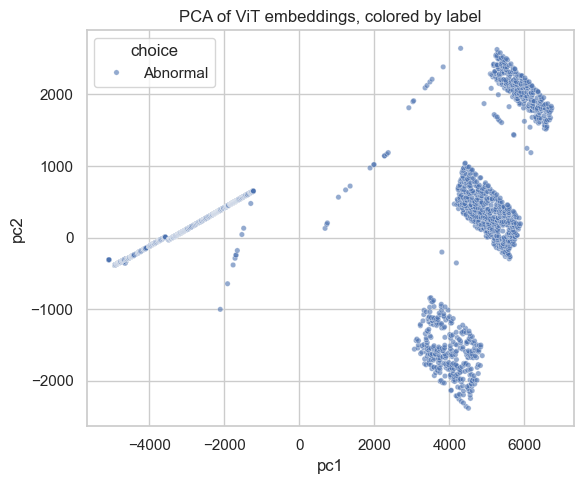

Explained variance by PC1 + PC2: 0.9999907318388226


In [8]:
# === Clean out rows with NaNs in the embedding columns =================
df_clean = df.dropna(subset=embed_cols)

print(
    f"Removed {len(df) - len(df_clean)} rows with NaNs in embedding columns "
    f"({len(df)} -> {len(df_clean)})."
)

X = df_clean[embed_cols].values

# Subsample if the dataset is very large for faster plotting
MAX_N = 5000
if X.shape[0] > MAX_N:
    sample_idx = np.random.choice(X.shape[0], size=MAX_N, replace=False)
    X_sample = X[sample_idx]
    df_sample = df_clean.iloc[sample_idx].reset_index(drop=True)
else:
    X_sample = X
    df_sample = df_clean.reset_index(drop=True)

# === PCA ===============================================================
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_sample)

pca_df = pd.DataFrame({
    "pc1": X_pca[:, 0],
    "pc2": X_pca[:, 1],
})

if LABEL_COL in df_sample.columns:
    pca_df[LABEL_COL] = df_sample[LABEL_COL].values
else:
    pca_df[LABEL_COL] = "unknown"

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=pca_df,
    x="pc1", y="pc2",
    hue=LABEL_COL,
    alpha=0.6,
    s=15,
)
plt.title("PCA of ViT embeddings, colored by label")
plt.tight_layout()
plt.show()

print("Explained variance by PC1 + PC2:", pca.explained_variance_ratio_.sum())

In [9]:
if CAMERA_COL in df.columns and LABEL_COL in df.columns:
    # Assume binary label where 1 = degraded / anomaly
    camera_stats = (
        df.groupby(CAMERA_COL)[LABEL_COL]
        .agg(["count", "mean"])
        .rename(columns={"mean": "anomaly_rate"})
        .sort_values("anomaly_rate", ascending=False)
    )

    display(camera_stats.head(10))

    plt.figure(figsize=(8,4))
    top_n = 20
    sns.barplot(
        data=camera_stats.head(top_n).reset_index(),
        x=CAMERA_COL, y="anomaly_rate",
    )
    plt.xticks(rotation=60, ha="right")
    plt.title(f"Top {top_n} cameras by anomaly rate")
    plt.tight_layout()
    plt.show()
else:
    print("Camera-level stats skipped (missing CAMERA_COL or LABEL_COL).")

Camera-level stats skipped (missing CAMERA_COL or LABEL_COL).
